In [16]:
import numpy as np
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
import os
from torchvision import datasets, transforms
from torch.optim import Adam

from pytorch_lightning import Trainer

import utils as utils

DATA_DIR = './fashionMNIST/'

In [25]:
# Setup pytorch and numpy for reproducability between runs.  That way we can
# make tweaks and see what the effect on performance is.  If we don't set this we will
# get different accuracy results between runs, and will complicate measuring the effect
# of our changes on the performance.
seed_val = 42
torch.manual_seed(seed_val)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed_val)

In [18]:
class LitMNIST(LightningModule):

    def __init__(self):
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = torch.nn.Conv2d(1, 32, 3)
        self.layer_2 = torch.nn.MaxPool2d(2)
        self.layer_3 = torch.nn.Conv2d(32, 64, 3)
        self.layer_4 = torch.nn.MaxPool2d(2)
        self.layer_5 = torch.nn.Conv2d(64, 64, 3)
        self.fc1 = torch.nn.Linear(64 * 3 * 3, 64)
        self.fc2 = torch.nn.Linear(64, 10)
        

    def forward(self, x):
        batch_size, channels, width, height = x.size()
        
        # (b, 1, 28, 28) -> (b, 1*28*28)
        # x = x.view(batch_size, -1)
        
        # conv + relu
        x = self.layer_1(x)
        x = torch.relu(x)
        
        # maxpool
        x = self.layer_2(x)
        
        # conv + relu
        x = self.layer_3(x)
        x = torch.relu(x)
        
        # maxpool
        x = self.layer_4(x)
        
        # conv + relu
        x = self.layer_5(x)
        x = torch.relu(x)

        # flatten
        x = torch.flatten(x, start_dim=1)
        
        # densely connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        
        x = self.fc2(x)
        
        # probability distribution over labels
        x = torch.log_softmax(x, dim=1)

        return x
    
    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

    def prepare_data(self):
        # transforms for images
        transform=transforms.Compose([transforms.ToTensor()])
        fmnist_train = FashionMNIST(DATA_DIR, train=True, download=True, transform=transform)
        self.fmnist_test = FashionMNIST(DATA_DIR, train=False, download=True, transform=transform)
        
        self.fmnist_train, self.fmnist_val = random_split(fmnist_train, [55000, 5000])
        
    def train_dataloader(self):
        return DataLoader(self.fmnist_train, batch_size=64)

    def val_dataloader(self):
        return DataLoader(self.fmnist_val, batch_size=64)

    def test_dataloader(self):
        return DataLoader(self.fmnist_test, batch_size=64)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.cross_entropy_loss(logits, y)
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.cross_entropy_loss(logits, y)
        
        return {'test_loss': loss}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'test_loss': avg_loss, 'log': tensorboard_logs}

In [19]:
net = LitMNIST()
x = torch.Tensor(1, 1, 28, 28)
out = net(x)

In [20]:
out

tensor([[-2.6061e+34, -6.6521e+34, -3.5787e+34, -4.7549e+34, -5.7543e+34,
         -7.2802e+33,  0.0000e+00, -5.6118e+34, -2.9600e+34, -7.8266e+34]],
       grad_fn=<LogSoftmaxBackward>)

In [21]:
net.prepare_data()

In [22]:
# Class map from the fashion mnist website https://github.com/zalandoresearch/fashion-mnist
classes = {0: 'T-shirt/top',
           1: 'Trouser',
           2: 'Pullover',
           3: 'Dress',
           4: 'Coat',
           5: 'Sandal',
           6: 'Shirt',
           7: 'Sneaker',
           8: 'Bag',
           9: 'Ankle Boot'}

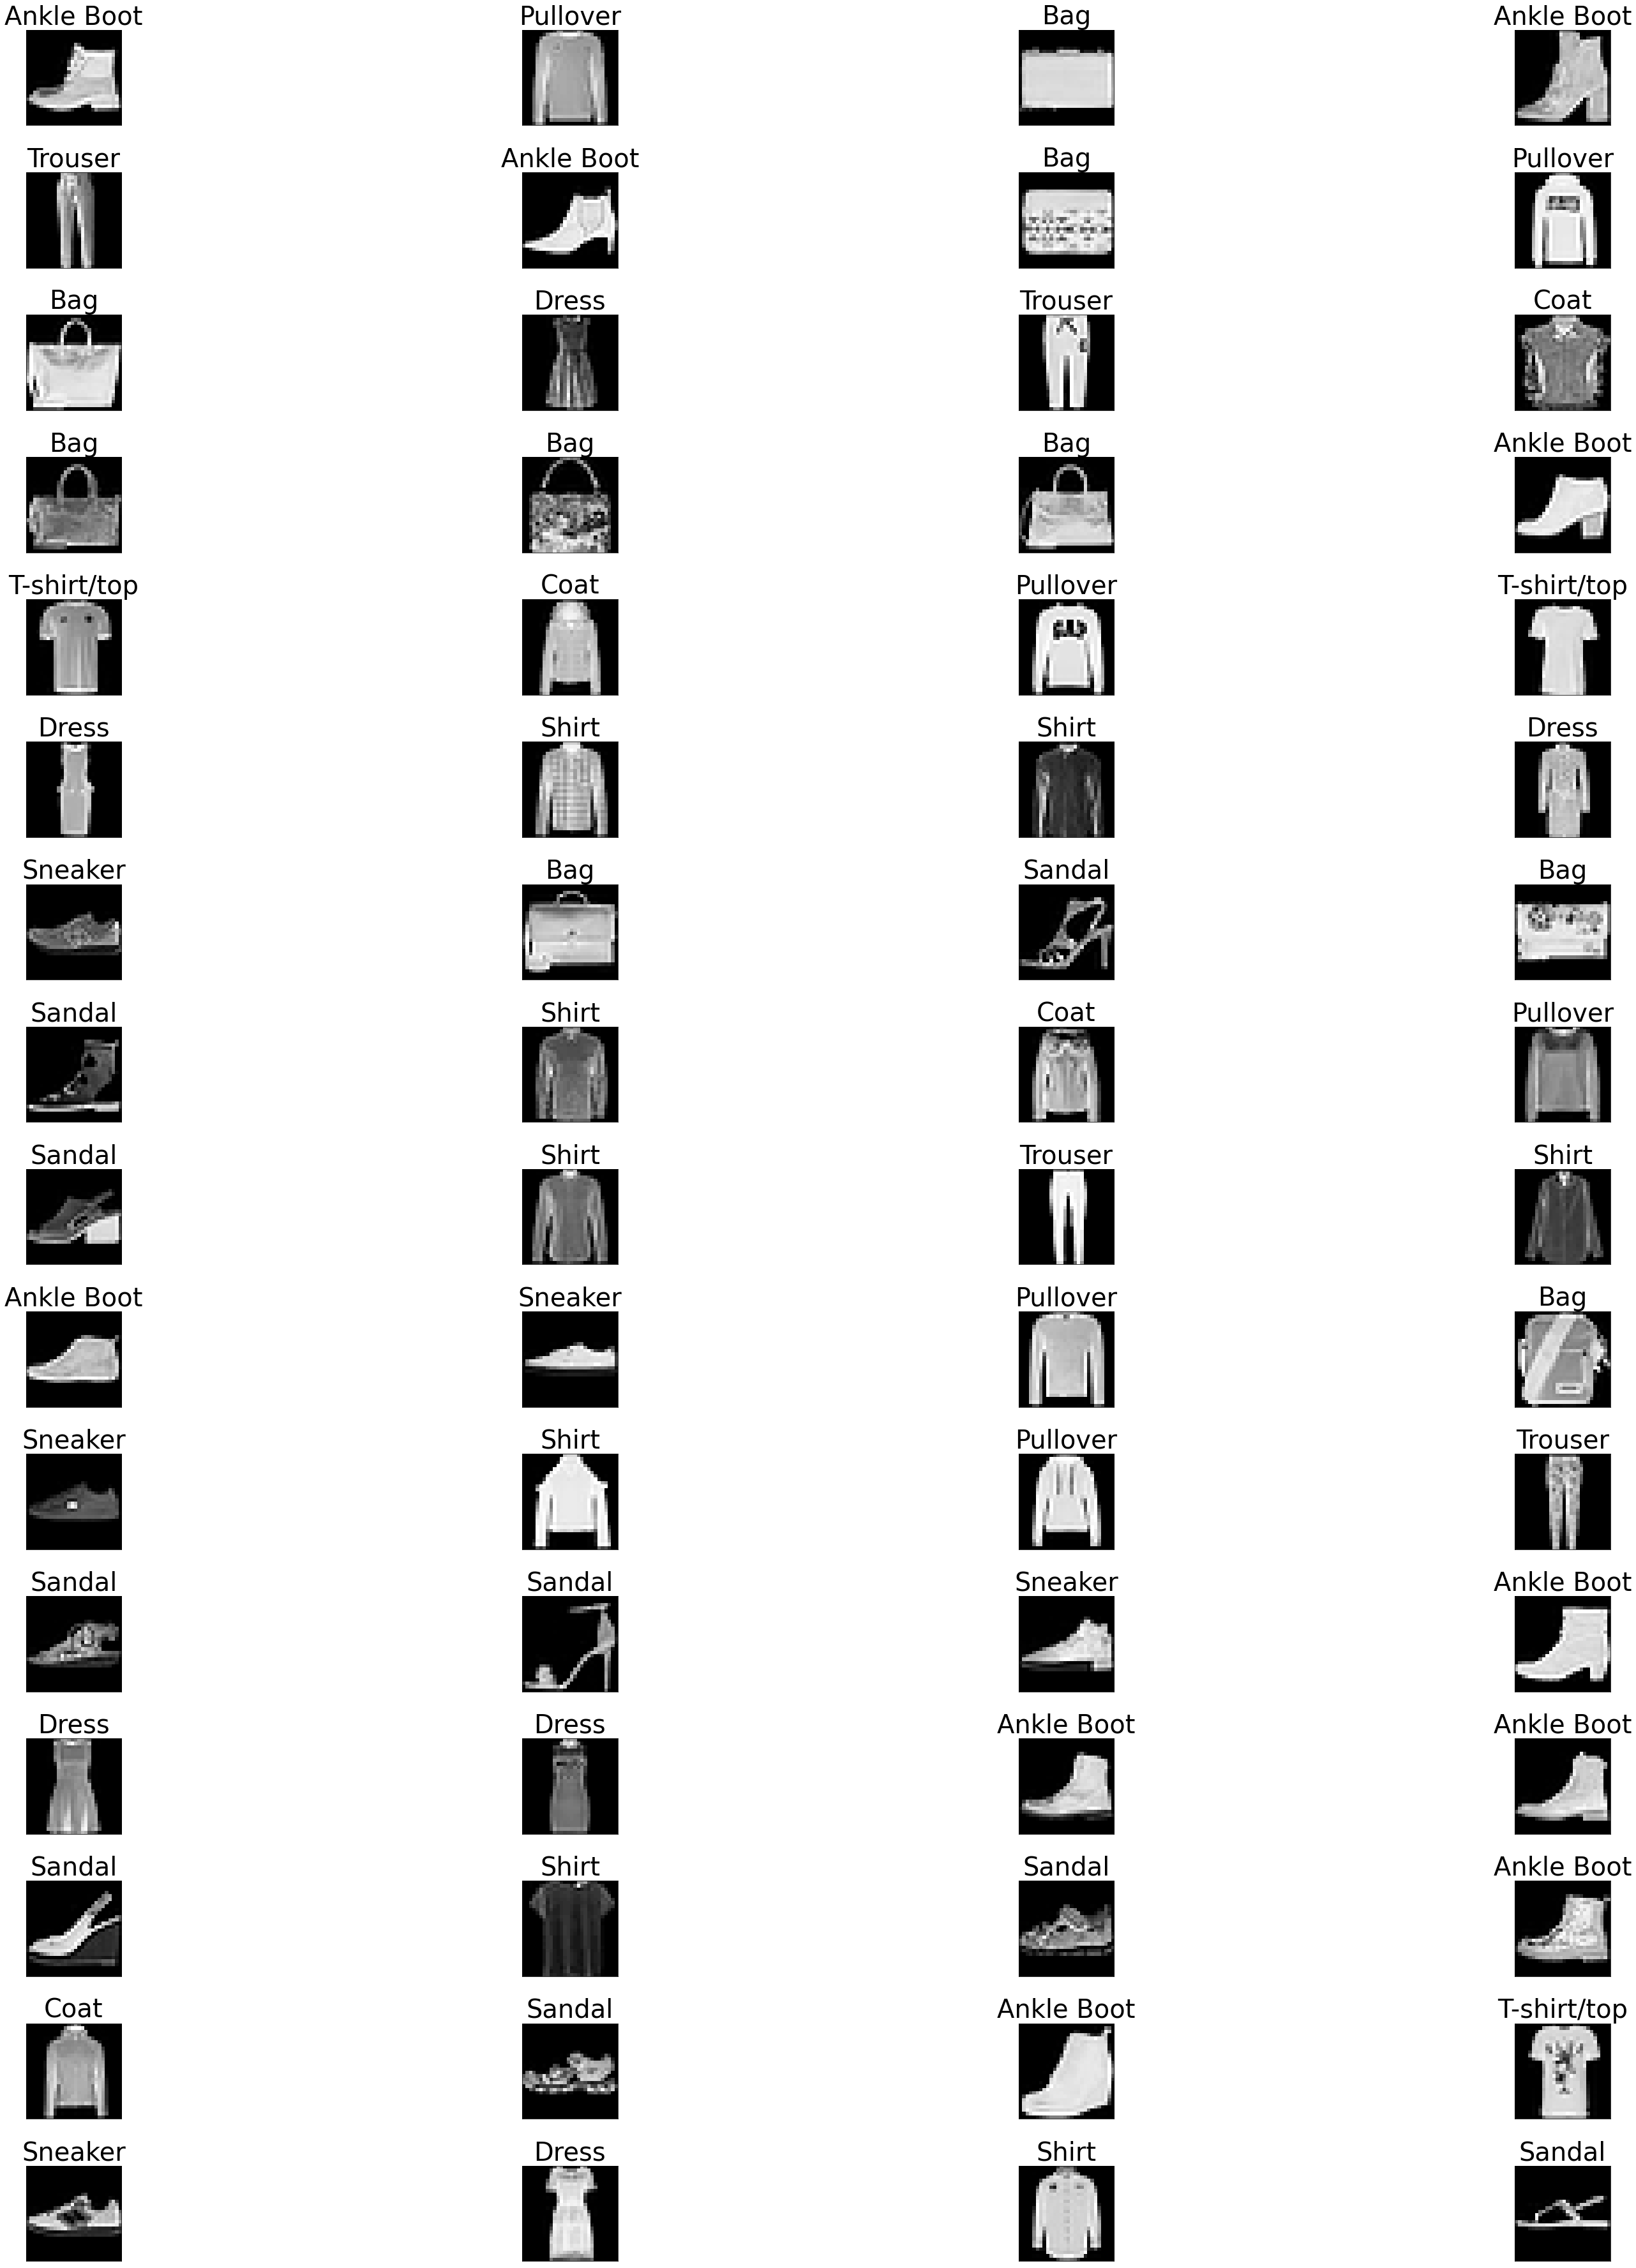

In [23]:
dl = net.train_dataloader()
utils.display_grid_data(dl, classes)

In [35]:
model = LitMNIST()
trainer = Trainer(max_epochs=5)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type      | Params
--------------------------------------
0 | layer_1 | Conv2d    | 320   
1 | layer_2 | MaxPool2d | 0     
2 | layer_3 | Conv2d    | 18 K  
3 | layer_4 | MaxPool2d | 0     
4 | layer_5 | Conv2d    | 36 K  
5 | fc1     | Linear    | 36 K  
6 | fc2     | Linear    | 650   


1

In [36]:
trainer.test()

--------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(0.3112)}
--------------------------------------------------------------------------------



{'test_loss': 0.311176061630249}

In [10]:
model.logger

In [11]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 452), started 21 days, 23:55:49 ago. (Use '!kill 452' to kill it.)

In [37]:
dl = model.test_dataloader()
import utils as utils

In [38]:
labels, predictions = utils.model_predictions(dl, model)
utils.measure_accuracy(labels, predictions, all_possible_labels=range(10))

Conf Matrix:
[[881   2  34  14   4   1  57   0   7   0]
 [  2 974   2  16   3   0   1   0   2   0]
 [ 10   1 865   8  57   0  56   0   3   0]
 [ 30   7  17 881  30   0  33   0   2   0]
 [  0   1  61  34 845   0  57   0   2   0]
 [  0   0   0   0   0 927   1  50   1  21]
 [162   2  95  19  94   0 617   0  11   0]
 [  0   0   0   0   0   2   0 962   0  36]
 [  3   1   6   2   3   1   5   4 973   2]
 [  1   0   0   0   0   2   0  33   0 964]]

Accuracy Score:
0.8889
